In [ ]:
from zipfile import ZipFile

zip_path = "/content/sentiment_images new.zip"


extract_path = "/content/i"

with ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Unzipping completed!")

Unzipping completed!


In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2

sentiment_df = pd.read_csv("/content/sentiment_data.csv")

sentiment_map = {'positive': 0, 'negative': 1, 'neutral': 2}
sentiment_df['sentiment'] = sentiment_df['sentiment'].map(sentiment_map)

texts = sentiment_df['text'].tolist()
sentiments = to_categorical(sentiment_df['sentiment'], num_classes=3)


tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=100)

vocab_size = len(tokenizer.word_index) + 1
max_seq_len = 100

img_size = (224, 224)
batch_size = 8

datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_directory(
    '/content/i/sentiment_images[1]/train',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    '/content/i/sentiment_images[1]/validation',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)


image_input = Input(shape=(224, 224, 3), name="image_input")
cnn_base = MobileNetV2(include_top=False, weights='imagenet', input_tensor=image_input)
x_img = GlobalAveragePooling2D()(cnn_base.output)


text_input = Input(shape=(max_seq_len,), name="text_input")
x_txt = Embedding(input_dim=vocab_size, output_dim=128)(text_input)
x_txt = LSTM(64)(x_txt)


combined = Concatenate()([x_img, x_txt])


identity_output = Dense(train_gen.num_classes, activation='softmax', name='identity_output')(combined)
sentiment_output = Dense(3, activation='softmax', name='sentiment_output')(x_txt)


model = Model(inputs=[image_input, text_input], outputs=[identity_output, sentiment_output])

model.compile(
    optimizer='adam',
    loss={
        'identity_output': 'categorical_crossentropy',
        'sentiment_output': 'categorical_crossentropy'
    },
    metrics={
        'identity_output': 'accuracy',
        'sentiment_output': 'accuracy'
    }
)

num_batches = len(train_gen)

for batch_index in range(num_batches):
    print(f"Training batch {batch_index + 1}/{num_batches}")

    img_batch, id_batch = next(train_gen)


    repeated_padded_sequences = np.repeat([padded_sequences[0]], repeats=img_batch.shape[0], axis=0)
    repeated_sentiment_labels = np.repeat([sentiments[0]], repeats=img_batch.shape[0], axis=0)

    history = model.fit(
        [img_batch, repeated_padded_sequences],
        {
            'identity_output': id_batch,
            'sentiment_output': repeated_sentiment_labels
        },
        epochs=1,
        verbose=1
    )


Found 45 images belonging to 3 classes.
Found 45 images belonging to 3 classes.


<ipython-input-2-76221b09bd35>:56: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  cnn_base = MobileNetV2(include_top=False, weights='imagenet', input_tensor=image_input)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Training batch 1/6
1/1 ━━━━━━━━━━━━━━━━━━━━ 36s 36s/step - identity_output_accuracy: 0.1250 - identity_output_loss: 2.0049 - loss: 3.1042 - sentiment_output_accuracy: 0.0000e+00 - sentiment_output_loss: 1.0993
Training batch 2/6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - identity_output_accuracy: 0.8750 - identity_output_loss: 0.3991 - loss: 1.4492 - sentiment_output_accuracy: 1.0000 - sentiment_output_loss: 1.0500
Training batch 3/6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - identity_output_accuracy: 1.0000 - identity_output_loss: 0.0867 - loss: 1.0852 - sentiment_output_accuracy: 1.0000 - sentiment_output_loss: 0.9985
Training batch 4/6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - identity_output_accuracy: 1.0000 - identity_output_loss: 0.0287 - loss: 0.9687 - sentiment_output_accuracy: 1.0000 - sentiment_output_loss: 0.9400
Training batch 5/6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - identity_output_accuracy: 1.0000 - identity_output_loss: 0.0

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

class_indices = train_gen.class_indices
idx_to_name = {v: k for k, v in class_indices.items()}

sentiment_map_reverse = {0: 'positive', 1: 'negative', 2: 'neutral'}


def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    return np.expand_dims(img_array, axis=0)


def preprocess_text(text, tokenizer, max_len=100):
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=max_len)
    return padded


def predict_identity_and_sentiment(img_path, text_input):
    img_input = preprocess_image(img_path)
    text_input_padded = preprocess_text(text_input, tokenizer)

    preds = model.predict([img_input, text_input_padded])

    identity_pred = np.argmax(preds[0])
    sentiment_pred = np.argmax(preds[1])

    identity_name = idx_to_name[identity_pred]
    sentiment_label = sentiment_map_reverse[sentiment_pred]

    return identity_name, sentiment_label


In [ ]:
def predict_identity_and_sentiment(img_path, text_input):

    img_input = preprocess_image(img_path)
    text_input_padded = preprocess_text(text_input, tokenizer)

    preds = model.predict([img_input, text_input_padded])


    identity_pred = np.argmax(preds[0])
    sentiment_pred = np.argmax(preds[1])


    identity_name = idx_to_name[identity_pred]
    sentiment_label = sentiment_map_reverse[sentiment_pred]

    return identity_name, sentiment_label


In [ ]:
image_path = "/content/i/sentiment_images[1]/train/Jothi/happy/IMG-20230912-WA0019 - Copy.jpg"
text_input = "I love this moment!."

name_pred, sentiment_pred = predict_identity_and_sentiment(image_path, text_input)

print("Predicted Name:", name_pred)
print("Predicted Sentiment:", sentiment_pred)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicted Name: Jothi
Predicted Sentiment: positive


In [ ]:
image_path = "/content/i/sentiment_images[1]/train/Mahadevan/happy/IMG20250408121637 - Copy (2).jpg"
text_input = "I am so tired and upset."

name_pred, sentiment_pred = predict_identity_and_sentiment(image_path, text_input)

print("Predicted Name:", name_pred)
print("Predicted Sentiment:", sentiment_pred)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicted Name: Mahadevan
Predicted Sentiment: positive


In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, SimpleRNN, Dense, Concatenate, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing import image

sentiment_df = pd.read_csv("/content/sentiment_data.csv")
sentiment_map = {'positive': 0, 'negative': 1, 'neutral': 2}
sentiment_df['sentiment'] = sentiment_df['sentiment'].map(sentiment_map)

texts = sentiment_df['text'].tolist()
sentiments = to_categorical(sentiment_df['sentiment'], num_classes=3)

tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=100)

vocab_size = len(tokenizer.word_index) + 1
max_seq_len = 100

img_size = (224, 224)
batch_size = 8

datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_directory(
    '/content/i/sentiment_images[1]/train',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    '/content/i/sentiment_images[1]/validation',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)


image_input = Input(shape=(224, 224, 3), name="image_input")
cnn_base = MobileNetV2(include_top=False, weights='imagenet', input_tensor=image_input)
x_img = GlobalAveragePooling2D()(cnn_base.output)

text_input = Input(shape=(max_seq_len,), name="text_input")
x_txt = Embedding(input_dim=vocab_size, output_dim=128)(text_input)
x_txt = SimpleRNN(64)(x_txt)

combined = Concatenate()([x_img, x_txt])

identity_output = Dense(train_gen.num_classes, activation='softmax', name='identity_output')(combined)
sentiment_output = Dense(3, activation='softmax', name='sentiment_output')(x_txt)

model = Model(inputs=[image_input, text_input], outputs=[identity_output, sentiment_output])
model.compile(
    optimizer='adam',
    loss={'identity_output': 'categorical_crossentropy', 'sentiment_output': 'categorical_crossentropy'},
    metrics={'identity_output': 'accuracy', 'sentiment_output': 'accuracy'}
)

num_batches = len(train_gen)

for batch_index in range(num_batches):
    print(f"Training batch {batch_index + 1}/{num_batches}")
    img_batch, id_batch = next(train_gen)
    repeated_padded_sequences = np.repeat([padded_sequences[0]], repeats=img_batch.shape[0], axis=0)
    repeated_sentiment_labels = np.repeat([sentiments[0]], repeats=img_batch.shape[0], axis=0)

    history = model.fit(
        [img_batch, repeated_padded_sequences],
        {'identity_output': id_batch, 'sentiment_output': repeated_sentiment_labels},
        epochs=1,
        verbose=1
    )

class_indices = train_gen.class_indices
idx_to_name = {v: k for k, v in class_indices.items()}
sentiment_map_reverse = {0: 'positive', 1: 'negative', 2: 'neutral'}

def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    return np.expand_dims(img_array, axis=0)

def preprocess_text(text, tokenizer, max_len=100):
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=max_len)
    return padded

def predict_identity_and_sentiment(img_path, text_input):
    img_input = preprocess_image(img_path)
    text_input_padded = preprocess_text(text_input, tokenizer)
    preds = model.predict([img_input, text_input_padded])

    identity_pred = np.argmax(preds[0])
    sentiment_pred = np.argmax(preds[1])

    identity_name = idx_to_name[identity_pred]
    sentiment_label = sentiment_map_reverse[sentiment_pred]

    return identity_name, sentiment_label

image_path = "/content/i/sentiment_images[1]/train/Jothi/happy/IMG20250408101814 - Copy.jpg"
text_input = "I love this moment!."

name_pred, sentiment_pred = predict_identity_and_sentiment(image_path, text_input)
print("Predicted Name:", name_pred)
print("Predicted Sentiment:", sentiment_pred)


Found 45 images belonging to 3 classes.
Found 45 images belonging to 3 classes.


<ipython-input-3-c2a15db578be>:54: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  cnn_base = MobileNetV2(include_top=False, weights='imagenet', input_tensor=image_input)


Training batch 1/6
1/1 ━━━━━━━━━━━━━━━━━━━━ 53s 53s/step - identity_output_accuracy: 0.3750 - identity_output_loss: 1.5050 - loss: 2.4439 - sentiment_output_accuracy: 1.0000 - sentiment_output_loss: 0.9389
Training batch 2/6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - identity_output_accuracy: 0.6250 - identity_output_loss: 1.4016 - loss: 1.9657 - sentiment_output_accuracy: 1.0000 - sentiment_output_loss: 0.5641
Training batch 3/6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - identity_output_accuracy: 0.8750 - identity_output_loss: 0.2811 - loss: 0.6190 - sentiment_output_accuracy: 1.0000 - sentiment_output_loss: 0.3379
Training batch 4/6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - identity_output_accuracy: 1.0000 - identity_output_loss: 0.0494 - loss: 0.2586 - sentiment_output_accuracy: 1.0000 - sentiment_output_loss: 0.2092
Training batch 5/6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - identity_output_accuracy: 0.8750 - identity_output_loss: 0.2009 - loss: 0.3355 - sentiment_output_accuracy: 1.000

In [ ]:
image_path = "/content/i/sentiment_images[1]/train/Jothi/happy/IMG20250408101828 - Copy.jpg"
text_input = "I love this moment!."

name_pred, sentiment_pred = predict_identity_and_sentiment(image_path, text_input)
print("Predicted Name:", name_pred)
print("Predicted Sentiment:", sentiment_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicted Name: Mahadevan
Predicted Sentiment: positive


In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, GRU, Dense, Concatenate, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing import image


sentiment_df = pd.read_csv("/content/sentiment_data.csv")

sentiment_map = {'positive': 0, 'negative': 1, 'neutral': 2}
sentiment_df['sentiment'] = sentiment_df['sentiment'].map(sentiment_map)

texts = sentiment_df['text'].tolist()
sentiments = to_categorical(sentiment_df['sentiment'], num_classes=3)


tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=100)

vocab_size = len(tokenizer.word_index) + 1
max_seq_len = 100

img_size = (224, 224)
batch_size = 8

datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_directory(
    '/content/i/sentiment_images[1]/train',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    '/content/i/sentiment_images[1]/validation',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)


image_input = Input(shape=(224, 224, 3), name="image_input")
cnn_base = MobileNetV2(include_top=False, weights='imagenet', input_tensor=image_input)
x_img = GlobalAveragePooling2D()(cnn_base.output)


text_input = Input(shape=(max_seq_len,), name="text_input")
x_txt = Embedding(input_dim=vocab_size, output_dim=128)(text_input)
x_txt = GRU(64)(x_txt)

combined = Concatenate()([x_img, x_txt])


identity_output = Dense(train_gen.num_classes, activation='softmax', name='identity_output')(combined)
sentiment_output = Dense(3, activation='softmax', name='sentiment_output')(x_txt)


model = Model(inputs=[image_input, text_input], outputs=[identity_output, sentiment_output])

model.compile(
    optimizer='adam',
    loss={
        'identity_output': 'categorical_crossentropy',
        'sentiment_output': 'categorical_crossentropy'
    },
    metrics={
        'identity_output': 'accuracy',
        'sentiment_output': 'accuracy'
    }
)

num_batches = len(train_gen)

for batch_index in range(num_batches):
    print(f"Training batch {batch_index + 1}/{num_batches}")

    img_batch, id_batch = next(train_gen)


    repeated_padded_sequences = np.repeat([padded_sequences[0]], repeats=img_batch.shape[0], axis=0)
    repeated_sentiment_labels = np.repeat([sentiments[0]], repeats=img_batch.shape[0], axis=0)


    model.fit(
        [img_batch, repeated_padded_sequences],
        {
            'identity_output': id_batch,
            'sentiment_output': repeated_sentiment_labels
        },
        epochs=1,
        verbose=1
    )


class_indices = train_gen.class_indices
idx_to_name = {v: k for k, v in class_indices.items()}
sentiment_map_reverse = {0: 'positive', 1: 'negative', 2: 'neutral'}

def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    return np.expand_dims(img_array, axis=0)

def preprocess_text(text, tokenizer, max_len=100):
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=max_len)
    return padded

def predict_identity_and_sentiment(img_path, text_input):
    img_input = preprocess_image(img_path)
    text_input_padded = preprocess_text(text_input, tokenizer)
    preds = model.predict([img_input, text_input_padded])

    identity_pred = np.argmax(preds[0])
    sentiment_pred = np.argmax(preds[1])

    identity_name = idx_to_name[identity_pred]
    sentiment_label = sentiment_map_reverse[sentiment_pred]

    return identity_name, sentiment_label

image_path = "/content/i/sentiment_images[1]/train/Jothi/happy/IMG20250408101814 - Copy.jpg"
text_input = "I love this moment!."

name_pred, sentiment_pred = predict_identity_and_sentiment(image_path, text_input)

print("Predicted Name:", name_pred)
print("Predicted Sentiment:", sentiment_pred)


Found 45 images belonging to 3 classes.
Found 45 images belonging to 3 classes.


<ipython-input-5-70eb9f80a631>:57: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  cnn_base = MobileNetV2(include_top=False, weights='imagenet', input_tensor=image_input)


Training batch 1/6
1/1 ━━━━━━━━━━━━━━━━━━━━ 30s 30s/step - identity_output_accuracy: 0.6250 - identity_output_loss: 0.7679 - loss: 1.8690 - sentiment_output_accuracy: 0.0000e+00 - sentiment_output_loss: 1.1010
Training batch 2/6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - identity_output_accuracy: 0.6250 - identity_output_loss: 0.6479 - loss: 1.6883 - sentiment_output_accuracy: 1.0000 - sentiment_output_loss: 1.0404
Training batch 3/6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - identity_output_accuracy: 0.7500 - identity_output_loss: 0.2583 - loss: 1.2401 - sentiment_output_accuracy: 1.0000 - sentiment_output_loss: 0.9817
Training batch 4/6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - identity_output_accuracy: 0.8750 - identity_output_loss: 0.3972 - loss: 1.3207 - sentiment_output_accuracy: 1.0000 - sentiment_output_loss: 0.9235
Training batch 5/6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - identity_output_accuracy: 0.8750 - identity_output_loss: 0.4560 - loss: 1.3201 - sentiment_output_accuracy: 1

In [ ]:
image_path = "/content/i/sentiment_images[1]/train/Mahadevan/sad/IMG20250408121708_01.jpg"
text_input = "I love this moment!."

name_pred, sentiment_pred = predict_identity_and_sentiment(image_path, text_input)

print("Predicted Name:", name_pred)
print("Predicted Sentiment:", sentiment_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicted Name: Aruna
Predicted Sentiment: positive


In [ ]:
import os
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from diffusers import StableDiffusionPipeline
import random


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


train_dir = "/content/i/images/train"
val_dir = "/content/i/images/validation"

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
emotion_labels = train_dataset.classes

print("Emotion Classes:", emotion_labels)


def get_emotion_model(num_classes):
    model = models.resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model.to(device)

model = get_emotion_model(num_classes=len(emotion_labels))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


def train_model(model, train_loader, val_loader, epochs=2):
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")
    torch.save(model.state_dict(), "emotion_model.pth")

train_model(model, train_loader, val_loader, epochs=2)


def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    return transform(image).unsqueeze(0).to(device)

def predict_emotion(image_tensor, model):
    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)
    return emotion_labels[predicted.item()]


def generate_emoji(emotion, prompt_prefix="emoji face of a"):
    prompt = f"{prompt_prefix} {emotion} person, cartoon, simple, emoji, expressive"
    pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4").to(device)
    image = pipe(prompt).images[0]
    return image


def run_sentiment_to_emoji(image_path):
    image_tensor = load_image(image_path)
    model.load_state_dict(torch.load("emotion_model.pth"))
    predicted_emotion = predict_emotion(image_tensor, model)
    print(f"Predicted Emotion: {predicted_emotion}")
    gen_img = generate_emoji(predicted_emotion)
    gen_img.show()
    gen_img.save(f"emoji_{predicted_emotion}.png")


run_sentiment_to_emoji("/content/i/images/train/happy/100.jpg")


Emotion Classes: ['happy', 'neutral', 'sad']


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/2, Loss: 329.8896
Epoch 2/2, Loss: 220.1459
Predicted Emotion: happy


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
run_sentiment_to_emoji("/content/i/images/train/neutral/10816.jpg")

HAPPY

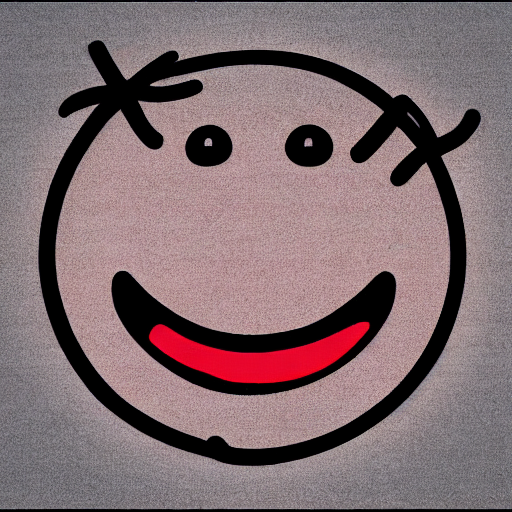

In [ ]:
from IPython.display import Image, display

image_path = '/content/emoji_happy.png'
display(Image(filename=image_path))

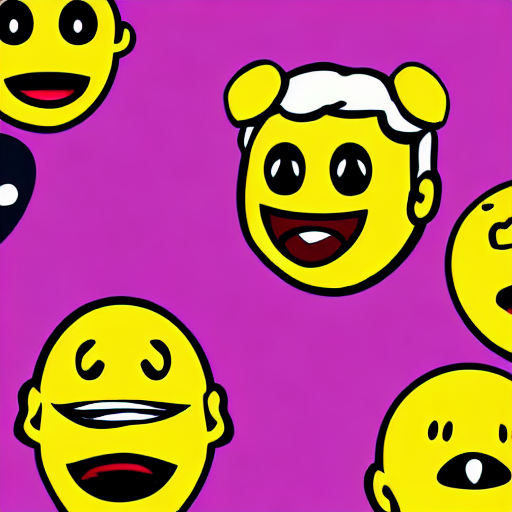

In [ ]:
from IPython.display import Image, display

image_path = '/content/emoji_happy.png'
display(Image(filename=image_path))


In [ ]:
run_sentiment_to_emoji("/content/i/images/train/sad/10498.jpg")

Predicted Emotion: sad


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

SAD

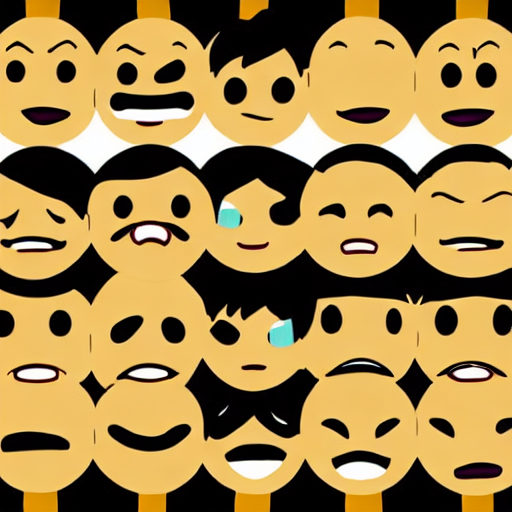

In [ ]:
from IPython.display import Image, display

image_path = '/content/emoji_sad (1).png'
display(Image(filename=image_path))

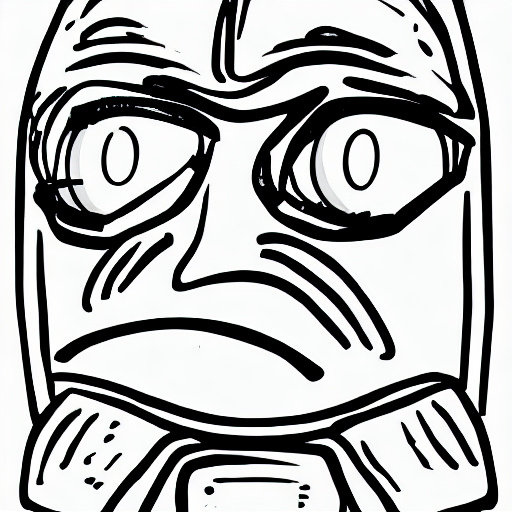

In [ ]:
from IPython.display import Image, display

image_path = '/content/emoji_sad.png'
display(Image(filename=image_path))

In [ ]:
run_sentiment_to_emoji("/content/i/images/train/neutral/10816.jpg")

NEUTRAL

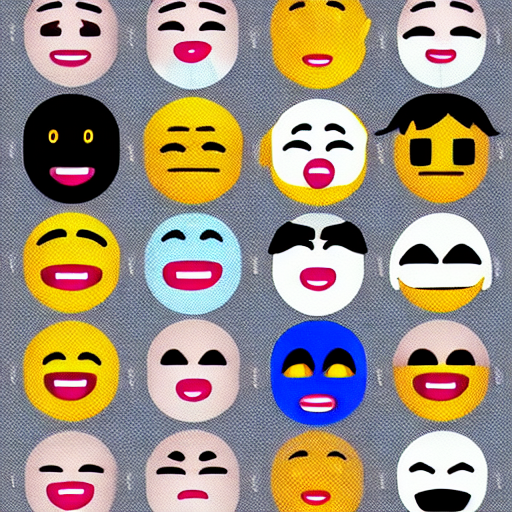

In [ ]:
from IPython.display import Image, display

image_path = '/content/emoji_neutral (1).png'
display(Image(filename=image_path))

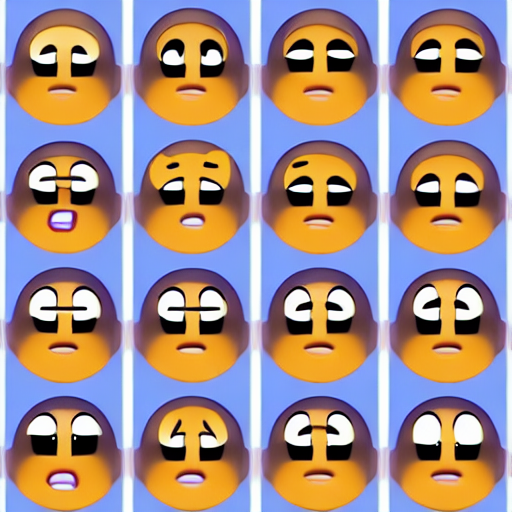

In [ ]:
from IPython.display import Image, display

image_path = '/content/emoji_neutral.png'
display(Image(filename=image_path))